In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
s2ag_papers = 'subugoe-collaborative.semantic_scholar.papers'
s2ag_venues = 'subugoe-collaborative.semantic_scholar.venues'
openalex_snapshot = 'subugoe-collaborative.openalex.works'
cr_snapshot = 'subugoe-collaborative.cr_instant.snapshot'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
oal_c = client.query(f"""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n
                    FROM {openalex_snapshot} AS oal
                    WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                        AND oal.type='article' AND is_paratext=False AND is_retracted=False
                    """).to_dataframe()

In [6]:
oal_c

,n
0,38254669


In [7]:
s2_c = client.query(f"""
                    SELECT COUNT(DISTINCT(externalids.DOI)) AS n
                    FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                    WHERE s2.year BETWEEN 2015 AND 2023 AND ptype = 'JournalArticle'
                    """).to_dataframe()

In [8]:
s2_c

,n
0,17743323


In [9]:
cr_c = client.query(f"""
                    SELECT COUNT(DISTINCT(cr.doi)) AS n
                    FROM {cr_snapshot} AS cr
                    LEFT JOIN {openalex_snapshot} AS oal
                        ON LOWER(cr.doi) = LOWER(oal.doi)
                    LEFT JOIN {s2ag_papers} AS s2
                        ON LOWER(cr.doi) = LOWER(s2.externalids.DOI)
                    WHERE cr.type = 'journal-article' AND issued >= '2015-01-01' 
                        AND issued < '2024-01-01' AND issued IS NOT NULL AND s2.externalids.DOI IS NULL AND oal.doi IS NULL
                    """).to_dataframe()

In [10]:
cr_c

,n
0,3547


In [11]:
oal_s2_cr_c = client.query(f"""
                            SELECT COUNT(DISTINCT(oal.doi)) AS n
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            JOIN {openalex_snapshot} AS oal
                                ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                            JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND oal.type='article' AND ptype='JournalArticle' AND cr.type='journal-article' AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [12]:
oal_s2_cr_c

,n
0,13860781


In [13]:
oal_s2_c = client.query(f"""
                         SELECT COUNT(DISTINCT(oal.doi)) AS n
                         FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                         JOIN {openalex_snapshot} AS oal
                             ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                         WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                             AND oal.type='article' AND ptype='JournalArticle' AND is_paratext=False
                         """).to_dataframe()

In [14]:
oal_s2_c

,n
0,13927415


In [15]:
oal_cr_c = client.query(f"""
                         SELECT COUNT(DISTINCT(oal.doi)) AS n
                         FROM {openalex_snapshot} AS oal
                         JOIN {cr_snapshot} AS cr
                             ON LOWER(oal.doi) = LOWER(cr.doi)
                         LEFT JOIN {s2ag_papers} AS s2
                             ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                         WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                             AND oal.type='article' AND cr.type='journal-article' AND is_paratext=False AND is_retracted=False AND s2.externalids.DOI IS NULL
                         """).to_dataframe()

In [16]:
oal_cr_c

,n
0,2082491


In [17]:
s2_cr_c = client.query(f"""
                         SELECT COUNT(DISTINCT(s2.externalids.DOI)) AS n
                         FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                         JOIN {cr_snapshot} AS cr
                             ON LOWER(s2.externalids.DOI) = LOWER(cr.doi)
                         LEFT JOIN {openalex_snapshot} AS oal
                             ON LOWER(s2.externalids.DOI) = LOWER(oal.doi)
                         WHERE s2.year BETWEEN 2015 AND 2023 AND ptype = 'JournalArticle' AND oal.doi IS NULL
                         """).to_dataframe()

In [18]:
s2_cr_c

,n
0,2990


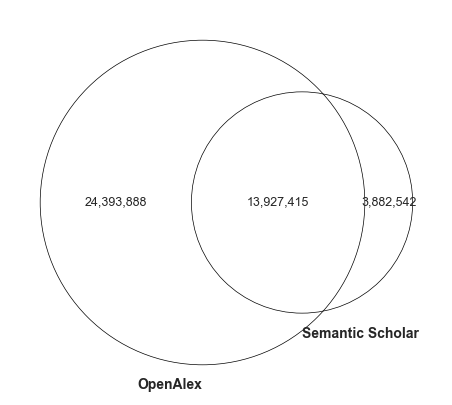

In [19]:
fig, ax = plt.subplots(figsize=(6,5))

subsets = (38254669-13860781, 17743323-13860781, 13927415)

out = venn2(subsets=subsets, 
      set_labels=('OpenAlex', 'Semantic Scholar'),
      set_colors=('white', 'white'),
      alpha=0.7)

venn2_circles(subsets=subsets, 
              linewidth=0.5)

for text in out.set_labels:
    text.set_font('Arial')
    text.set_fontsize(10)
    text.set_fontweight('bold')
for text in out.subset_labels:
    text.set_font('Arial')
    text.set_fontsize(9)
    s = int(text.get_text())
    text.set_text(f"{s:,}")
    
plt.show()
fig.savefig(f'media/venn_s2_oal.png', format='png', bbox_inches='tight', dpi=500)

In [20]:
oal_s2_ref_sum = client.query(f"""
                                SELECT 
                                    SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                    SUM(s2.referencecount) AS s2_ref_sum
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND type='article' AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [21]:
oal_s2_ref_sum

,oal_ref_sum,s2_ref_sum
0,852210046,866794854


In [22]:
oal_s2_ref_avg = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND type='article' AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [23]:
oal_s2_ref_avg

,oal_ref_avg,s2_ref_avg
0,23.113289,23.508852


In [24]:
oal_ref_sum = client.query(f"""
                            SELECT 
                                SUM(oal.referenced_works_count) AS oal_ref_sum, 
                            FROM {openalex_snapshot} AS oal
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND type='article' AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [25]:
oal_ref_sum

,oal_ref_sum
0,850164951


In [26]:
oal_ref_avg = client.query(f"""
                            SELECT 
                                AVG(oal.referenced_works_count) AS oal_ref_avg, 
                            FROM {openalex_snapshot} AS oal
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND type='article' AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [27]:
oal_ref_avg

,oal_ref_avg
0,18.441539


In [28]:
s2_ref_sum = client.query(f"""
                            SELECT 
                                SUM(s2.referencecount) AS s2_ref_sum
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            WHERE s2.year BETWEEN 2015 AND 2023 AND ptype = 'JournalArticle'
                            """).to_dataframe()

In [29]:
s2_ref_sum

,s2_ref_sum
0,626118429


In [30]:
s2_ref_avg = client.query(f"""
                            SELECT 
                                AVG(s2.referencecount) AS s2_ref_avg
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            WHERE s2.year BETWEEN 2015 AND 2023 AND ptype = 'JournalArticle'
                            """).to_dataframe()

In [31]:
s2_ref_avg

,s2_ref_avg
0,34.209228


In [32]:
oal_s2_ref_sum_y = client.query(f"""
                                SELECT 
                                    SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                    SUM(s2.referencecount) AS s2_ref_sum,
                                    SUM(cr.references_count) AS cr_ref_sum,
                                    oal.publication_year
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type='article' AND is_paratext=False AND is_retracted=False
                                GROUP BY publication_year
                                """).to_dataframe()

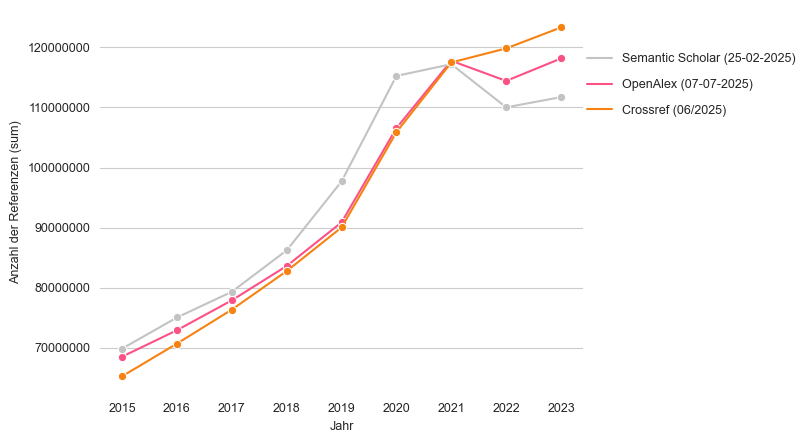

In [33]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_s2_ref_sum_y[['oal_ref_sum', 'publication_year']],
             x='publication_year',
             y='oal_ref_sum',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_sum_y[['s2_ref_sum', 'publication_year']],
             x='publication_year',
             y='s2_ref_sum',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_sum_y[['cr_ref_sum', 'publication_year']],
             x='publication_year',
             y='cr_ref_sum',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Anzahl der Referenzen (sum)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (07-07-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (06/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/s2_oal_cr_sum_ref.png', format='png', bbox_inches='tight', dpi=500)

In [34]:
oal_s2_ref_avg_y = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg,
                                    AVG(cr.references_count) AS cr_ref_avg,
                                    publication_year
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type='article' AND is_paratext=False AND is_retracted=False
                                GROUP BY publication_year
                                """).to_dataframe()

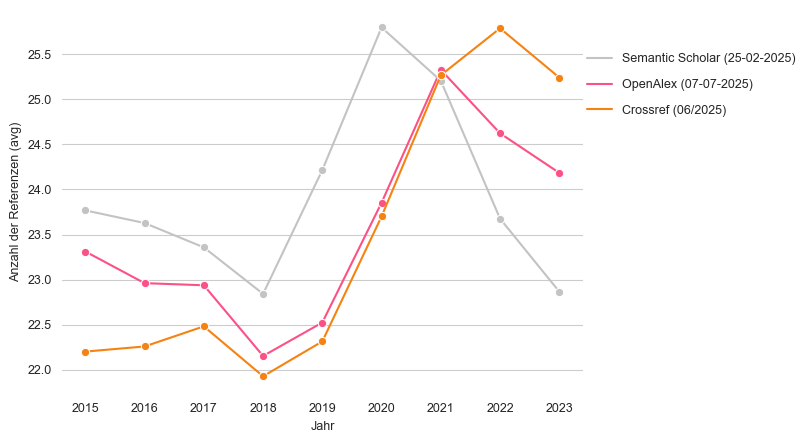

In [35]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_s2_ref_avg_y[['oal_ref_avg', 'publication_year']],
             x='publication_year',
             y='oal_ref_avg',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_avg_y[['s2_ref_avg', 'publication_year']],
             x='publication_year',
             y='s2_ref_avg',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_avg_y[['cr_ref_avg', 'publication_year']],
             x='publication_year',
             y='cr_ref_avg',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Anzahl der Referenzen (avg)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (07-07-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (06/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/s2_oal_cr_avg_ref.png', format='png', bbox_inches='tight', dpi=500)

In [36]:
oal_s2_ref_avg_y = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg,
                                    AVG(cr.references_count) AS cr_ref_avg
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type='article' AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [37]:
oal_s2_ref_avg_y

,oal_ref_avg,s2_ref_avg,cr_ref_avg
0,23.650929,23.972912,23.675267
